Cylinder boundary conditions check: PASSED. No inadmissible boundaries detected.


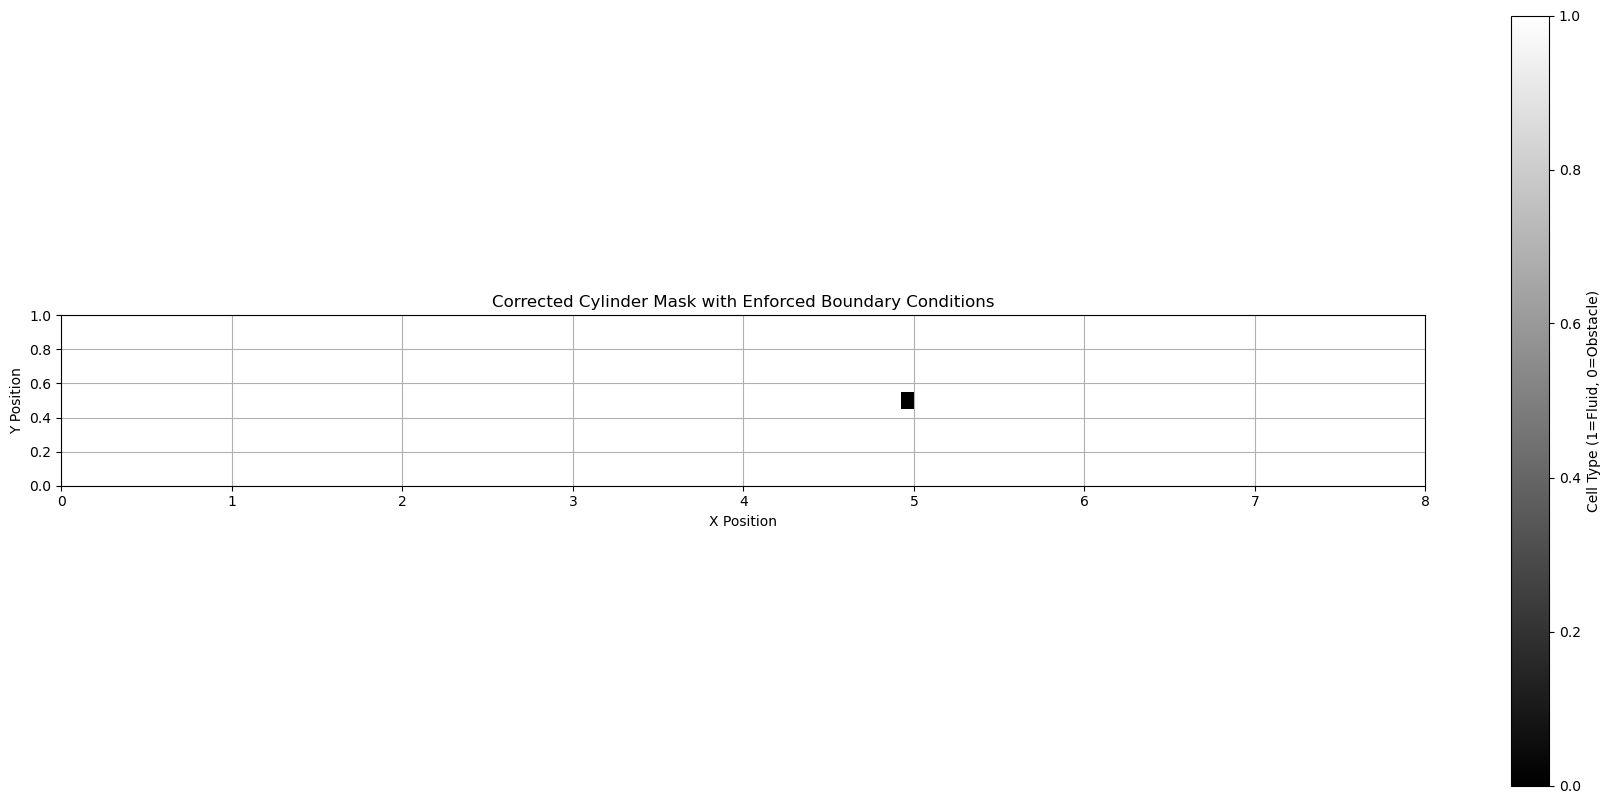

Number of iteration needed to simulate Normalized time : 417
Iteration : 1
 Computing LU_piv for the first time...
🔍 Pressure Solve Residual: 7.45660e-15
Iteration : 2
 Reusing precomputed LU_piv.
🔍 Pressure Solve Residual: 8.38974e-15
Iteration : 3
 Reusing precomputed LU_piv.
🔍 Pressure Solve Residual: 9.55832e-15
Iteration : 4
 Reusing precomputed LU_piv.
🔍 Pressure Solve Residual: 9.76194e-15
Iteration : 5
 Reusing precomputed LU_piv.
🔍 Pressure Solve Residual: 1.00185e-14
Iteration : 6
 Reusing precomputed LU_piv.
🔍 Pressure Solve Residual: 1.08038e-14
Iteration : 7
 Reusing precomputed LU_piv.
🔍 Pressure Solve Residual: 1.18319e-14
Iteration : 8
 Reusing precomputed LU_piv.
🔍 Pressure Solve Residual: 1.15603e-14
Iteration : 9
 Reusing precomputed LU_piv.
🔍 Pressure Solve Residual: 1.08175e-14
Iteration : 10
 Reusing precomputed LU_piv.
🔍 Pressure Solve Residual: 1.08025e-14
Iteration : 11
 Reusing precomputed LU_piv.
🔍 Pressure Solve Residual: 1.13211e-14
Iteration : 12
 Reusing 

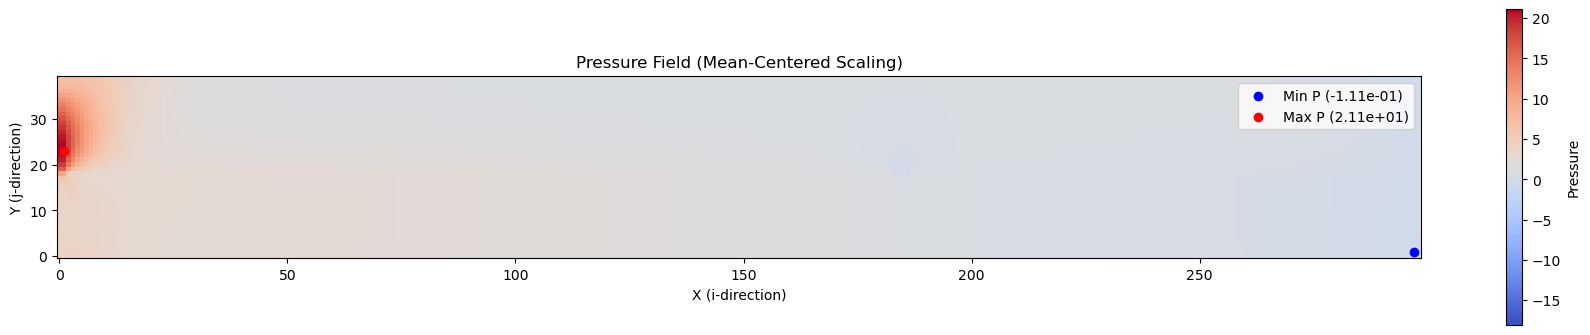

In [8]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, linalg
from scipy.sparse.linalg import spsolve
import math
from scipy.linalg import lu_factor, lu_solve




Lx,Ly =  8,1                            # Length of the cavity (m), Decided Arbitrarily.
Nx,Ny = 300,41                          # Number of total grid points (including domain and boundry).

domain_grid_x = Nx-2                 # Number of grid points in the domain.
domain_grid_y = Ny-2

num_of_domain_cells_x = Nx-3         # Number of cells in the domain.
num_of_domain_cells_y = Ny-3

num_of_tot_cells_x = Nx-1            # Number of cells in total.
num_of_tot_cells_y = Ny-1
i_max = num_of_domain_cells_x       # Max columm index inside the domain.
j_max = num_of_domain_cells_y       # Max row index inside the domain.
i_min = 1                         # Min columm index inside the domain.
j_min = 1                         # Min row index inside the domain.

dx = Lx / num_of_domain_cells_x      # Grid spacing.
dy = Ly / num_of_tot_cells_y                           # Uniform grid for a square grid.

"""Cylinder properties"""
R = 0.05  # Cylinder radius
cx, cy = 5, 0.5  # Cylinder center position

"""Physical parameters"""
Re = 100                     # Reynolds number.
U_mean = 1.5                 # The maximum velocity of the parabolic inflow velocity
U_max=2.25
nu = U_mean * (2 * R) / Re  # Kinematic viscosity
rho = 1.0



"""Masking the Cylinder with Enforced Boundary Conditions"""
# Obstacle mask (1 = fluid, 0 = cylinder)
flag = np.ones((num_of_tot_cells_y, num_of_tot_cells_x), dtype=int)

# Mark cylinder in the grid
for i in range(num_of_tot_cells_x+1):
    for j in range(num_of_tot_cells_y+1):
        x, y = (i + 0.5) * dx, (j + 0.5) * dy  # Cell center
        if (x - cx)**2 + (y - cy)**2 < R**2:  # Inside the cylinder
            flag[j, i] = 0  # Initially set as obstacle

# Post-processing: Remove inadmissible boundary cells (delete any cylinder cells which border 3 or more fluid cells)
for i in range(1, num_of_tot_cells_x):  # Avoid ghost cells
    for j in range(1, num_of_tot_cells_y):
        if flag[j, i] == 0:  # Only check obstacle cells
            # Count adjacent fluid cells
            adjacent_fluid = sum([flag[j, i-1], flag[j, i+1], flag[j-1, i], flag[j+1, i]])

            if adjacent_fluid >= 3:  # More than 2 adjacent fluid cells (inadmissible boundary)
                flag[j, i] = 1  # Convert back to fluid to avoid issues

# **Final validation: Ensure no invalid boundaries remain**
invalid_boundary_found = False
for i in range(1, num_of_tot_cells_x):  # Avoid ghost cells
    for j in range(1, num_of_tot_cells_y):
        if flag[j, i] == 0:  # Only check obstacle cells
            adjacent_fluid = sum([flag[j, i-1], flag[j, i+1], flag[j-1, i], flag[j+1, i]])
            if adjacent_fluid >= 3:
                invalid_boundary_found = True
                print(f" ERROR: Inadmissible boundary at (i={i}, j={j}) - {adjacent_fluid} adjacent fluid cells!")

if invalid_boundary_found:
    raise ValueError(" ERROR: Cylinder masking failed! Inadmissible boundaries detected. Check grid resolution or obstacle size.")

print("Cylinder boundary conditions check: PASSED. No inadmissible boundaries detected.")

# **Visualize the updated flag matrix**
plt.figure(figsize=(22, 10))
plt.imshow(flag, cmap='gray', origin='lower', extent=[0, Lx, 0, Ly])
plt.colorbar(label="Cell Type (1=Fluid, 0=Obstacle)")
plt.title("Corrected Cylinder Mask with Enforced Boundary Conditions")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.grid()
plt.show()



def calculate_time_step(Re, dx, dy, u_max, tau=0.5):
    """
    Parameters:
        Re (float): Reynolds number.
        dx (float): Grid spacing in the x-direction.
        dy (float): Grid spacing in the y-direction.
        u_max (float): Maximum velocity in the x-direction.
        tau (float): Safety factor (default = 1).
    Returns:
        dt (float): Calculated time step (Delta t).
    """
    # Calculate the first term of the criterion:
    term1 = (Re / 2) * (1/((1 / dx**2) + (1 / dy**2)))
    dt1 = term1

    # Calculate the second term of the criterion:
    if u_max != 0:
        dt2 = dx / abs(u_max)
    else:
        dt2 = float('inf')  

    # Compute the minimum of the two terms:
    dt = tau * min(dt1, dt2) #This is the time step condition.
    
    return dt



def Apply_Velocity_Boundry_Conditions(U,V,U_avg=1.5):
    """
    Parameters:
        U (2D numpy array): Horizontal velocity.
        V (2D numpy array): Vertical velocity.
        i_max (int): Max columm index inside the domain.
        u_max (float): Max row index inside the domain.
    Returns:
        U,V (2D numpy array): Corresponding arrays after apllying B.C.
    """
    #Left Boundry:
    V[:,0] = -V[:,1]                # No - Slip
                       # No - Penetration
    U_max= 1.5 *U_avg
    for j in range(1,j_max+1):
        y = j*dy
        U[j,0] = 4*U_max * (y*(Ly-y)) / Ly**2

    #Right Boundry:
    V[:,-1] = V[:,-2]               # No - Slip
    U[:,-2] = U[:,-3]               # No - Penetration
    

    #Upper Boundry:
    U[-1,:] = -U[-2,:]              # No - Slip
    V[-2,:] = 0                     # No - Penetration

    #Buttom Boundry:
    U[0,:] = -U[1,:]                # No - Slip
    V[0,:] = 0                      # No - Penetration


    #Cylinder boundry condition!!!!!!!
    for j in range(1, j_max):
        for i in range(1, i_max):
            West=False
            East=False
            South=False
            North=False
            if flag[j, i] == 1:  # Cylinder cell
                # Enforce no penetration by setting normal velocities properly
                if flag[j, i-1] == 0:  # West Boundry
                    V[j, i] = -V[j, i-1]
                    U[j, i-1] = 0
                    V[j-1,i] = -V[j-1,i-1]
                    West=True

                if flag[j, i+1] == 0:  # East boundry
                    V[j, i] = -V[j, i+1]
                    U[j, i+1] = 0
                    V[j-1,i] = -V[j-1,i+1]
                    East=True

                if flag[j+1, i] == 0:  # North boundry
                    U[j, i-1] = -U[j+1, i-1]
                    V[j, i] = 0
                    U[j,i] = -U[j+1,i]
                    North=True

                if flag[j-1, i] == 0:  # South Boundry
                    U[j, i-1] = -U[j-1, i-1]
                    V[j-1, i] = 0
                    U[j,i] = -U[j-1,i]
                    South=True

                # Checking corner:
                if West==True and South==True:
                    U[j,i+1]=-U[j-1,i+1]
                    V[j+1,i] = -V[j+1,i-1]
                    V[j,i] = 0
                    U[j,i] = 0

                if South==True and East==True:
                    U[j,i-1] = -U[j-1,i-1]
                    V[j+1,i] = -V[j+1,i+1]
                    V[j,i] = 0
                    U[j,i] = 0

                if North==True and East==True:
                    U[j,i-1] = -U[j+1,i-1]
                    V[j-1,i] = -V[j-1,i+1]
                    V[j,i] = 0
                    U[j,i] = 0

                if West==True and North==True:
                    U[j,i+1] = -U[j+1,i+1]
                    V[j-1,i] = -V[j-1,i-1]
                    V[j,i] = 0
                    U[j,i] = 0


    return U, V


def du_dx(u,j,i,dx):
    

    du_dx = (u[j, i] - u[j, i-1]) / dx
    return du_dx

def dv_dy(v,j,i,dy):
    

    dv_dy = (v[j, i] - v[j-1, i]) / dy
    return dv_dy

def d2f_dx2(f,j,i,dx):
    

    d2f_dx2 = (f[j, i+1] - 2 * f[j,i] + f[j, i-1]) / dx**2
    return d2f_dx2

def d2f_dy2(f,j,i,dy):
    

    d2f_dy2 = (f[j+1,i] - 2 * f[j,i] + f[j-1, i]) / dy**2
    return d2f_dy2

def dp_dx(p,j,i,dx):
    

    dp_dx = (p[j, i+1] - p[j, i]) / dx
    return dp_dx

def dp_dy(p,j,i,dy):
    

    dp_dy = (p[j+1, i] - p[j, i]) / dy
    return dp_dy

def duv_dy(u,v,j,i,dy):
    

    d_uv_dy = ((1 / dy) * (((v[j, i] + v[j, i+1]) / 2) * ((u[j, i] + u[j+1, i]) / 2) - ((v[j-1, i] + v[j-1, i+1]) / 2) * ((u[j-1, i] + u[j, i]) / 2)))
    return d_uv_dy

def duv_dx(u,v,j,i,dx):
    

    d_uv_dx = ((1 / dx) * (((u[j, i] + u[j+1, i]) / 2) * ((v[j, i] + v[j, i+1]) / 2) - ((u[j, i-1] + u[j+1, i-1]) / 2) * ((v[j, i-1] + v[j, i]) / 2)))
    return d_uv_dx

def du2_dx(u,j,i,dx):
    
    d_u2_dx = ((1 / dx) * ((((u[j,i] + u[j, i+1]) / 2)**2) - (((u[j, i-1] + u[j,i]) / 2)**2)))
    return d_u2_dx

def dv2_dy(v,j,i,dy):
    
    d_v2_dy = ((1 / dy) *((((v[j,i] + v[j+1, i]) / 2)**2) - (((v[j-1, i] + v[j,i]) / 2)**2)))
    return d_v2_dy

def F_ji(U,V,j,i,dt, dx, dy=dx, gx=0):
    

    F_ji = U[j,i] + dt * ((1/Re) * (d2f_dx2(U,j,i,dx) + d2f_dy2(U,j,i,dy)) - du2_dx(U,j,i,dx) - duv_dy(U,V,j,i,dy) + gx)
    return F_ji

def G_ji(U,V,j,i,dt,dx,dy,gy=0):
    

    G_ji = V[j,i] + dt* ((1/Re)*(d2f_dx2(V,j,i,dx)+d2f_dy2(V,j,i,dy))-duv_dx(U,V,j,i,dx)-dv2_dy(V,j,i,dy) + gy)
    return G_ji

def Solve_For_F_G(U,V,j_max,i_max,dt,dx,dy,flag):
    
    F_n = np.zeros((j_max+1,i_max+1))                #initializing F_n
    G_n = np.zeros((j_max+1,i_max+1))                #initializing G_n
    K=False
    #Calculating F_ji, G_ji values and appending to the F_n, G_n Matrices
    for j in range(1, j_max+1):
        for i in range(1, i_max+1):
            West, East, South, North = False, False, False, False
            if flag[j,i]==1:

                if flag[j,i+1]==0:                       #East boundry
                    F_n[j,i]=U[j,i]                  #Boundry condition
                    G_n[j,i]=G_ji(U,V,j,i,dt,dx,dy)
                    K=True
                    East = True



                if flag [j,i-1] ==0:                #West boundry
                    F_n[j,i] = F_ji(U,V,j,i,dt,dx,dy)
                    G_n[j,i] = G_ji(U,V,j,i,dt,dx,dy)
                    F_n[j,i-1] = U[j,i-1]
                    K=True
                    West = True

                if flag[j+1,i] ==0:              #North Boundry
                    F_n[j,i]=F_ji(U,V,j,i,dt,dx,dy)
                    G_n[j,i]=V[j,i]
                    K=True
                    North = True

                if flag[j-1,i] ==0:               # South boundry
                    F_n[j,i]=F_ji(U,V,j,i,dt,dx,dy)
                    G_n[j,i]=G_ji(U,V,j,i,dt,dx,dy)
                    G_n[j-1,i] = V[j-1,i]
                    K=True
                    South = True

                if K==False:
                    F_n[j,i]=F_ji(U,V,j,i,dt,dx,dy)
                    G_n[j,i]=G_ji(U,V,j,i,dt,dx,dy)

                # Corner Cases (Set Flux F to Zero)
                if West and South:  # B_SW
                    F_n[j, i-1] = 0
                    G_n[j-1, i] = 0

                if South and East:  # B_SE
                    F_n[j, i] = 0
                    G_n[j-1, i] = 0

                if North and East:  # B_NE
                    F_n[j, i] = 0
                    G_n[j, i] = 0

                if West and North:  # B_NW
                    F_n[j, i-1] = 0
                    G_n[j, i] = 0
            if flag[j,i]==0:
                F_n[j, i] = 0  # Apply no-slip
                G_n[j, i] = 0

    for i in range (1, i_max):
        F_n[j_max,i] = F_ji(U,V,j_max,i,dt,dx,dy)

    # Last columm of the calculated only for the F_n:
    for j in range(1, j_max):
        G_n[j, i_max] = G_ji(U,V,j,i_max,dt,dx,dy)

    #Apllying boundry conditions to F_n, G_n:
    F_n[1:j_max+1, 0]=U[1:j_max+1, 0]
    F_n[1:j_max+1,i_max] = U[1:j_max+1, i_max]
    G_n[0, 1:i_max+1] = V[0, 1:i_max+1]
    G_n[j_max, 1:i_max+1] = V[j_max,1:i_max+1]

    return F_n,G_n


def k(j,i,num_of_cols=num_of_domain_cells_x):
    """
    Parameter:
    j(int): Column number in the pressure matrix.
    i(int): Row number in the pressure matrix .
    num_of_cols(int): Number of columns in the pressure matrix.
    :return:
    k: index for location in the matrix
    """
    k_ji= (j-1)*num_of_cols + i -1 #Location on the flatten array (Each row in A is a flatten array of 1 by i_max * j_max).
    return k_ji


def Pressure_BC(P_it1,P_it,j_max,i_max):
    for j in range(1,j_max+1):
        for i in range(1,i_max+1):
            West=False
            East=False
            South=False
            North=False
            if flag[j,i]==1:
                if flag[j,i-1]==0:           #West boundry
                    P_it1[j,i-1] = P_it[j, i]
                    West =True

                if flag[j,i+1]==0:          #East is boundry
                    P_it1[j,i+1] = P_it[j, i]
                    East =True

                if flag[j-1,i]==0:          # South boundry
                    P_it1[j-1,i] = P_it[j, i]
                    South =True

                if flag[j+1,i]==0:           # North boundry
                    P_it1[j+1,i] = P_it[j, i]
                    North =True

            # Checking corner:
                if West==True and South==True:
                    P_it1[j,i] = (P_it[j, i-1] + P_it[j-1, i])/2

                if South==True and East==True:
                    P_it1[j,i] = (P_it[j-1, i] + P_it[j, i+1])/2

                if North==True and East==True:
                    P_it1[j,i] = (P_it[j+1, i] + P_it[j, i+1])/2

                if West==True and North==True:
                    P_it1[j,i] = (P_it[j, i-1] + P_it[j+1, i])/2
    return P_it1


LU_piv = None

def Solving_For_Pressure(U,V,P_it,j_max,i_max,dt,dx,dy,flag):
    global LU_piv

    F_n ,G_n = Solve_For_F_G(U,V,j_max,i_max,dt,dx,dy,flag)      # Getting the F_n G_n Auxiliary matrices
    # Create a copy of the new pressure field

    Num_of_eq= num_of_domain_cells_x*num_of_domain_cells_y      # Calculating the number of equations needed to solve the Poisson linear system of equations.
    A = np.zeros((Num_of_eq, Num_of_eq))
    rhs = np.zeros((num_of_tot_cells_y,num_of_tot_cells_x))
    b = np.zeros((Num_of_eq,1))
    P_it1 = np.copy(P_it)          #copying P_it to P_it1 where it1 is the next time step
    P_it1=Pressure_BC(P_it1,P_it,j_max,i_max)

    omega = 0.5
    Denomenator = ( 2 / (dx**2) ) +  ( 2 / (dy**2) )
    factor = omega / Denomenator


    for i in range(1,i_max+1):
        for j in range(1,j_max+1):
            if flag[j,i]==1:
                #lhs_value = ( P_it1[j, i] - factor * (( P_it1[j, i-1]) / (dx**2) + ( P_it1[j-1, i]) / (dy**2) ) )
                A[k(j,i),k(j,i)] = 1
                A[k(j,i),k(j,i-1)] = -factor / dx**2
                A[k(j,i),k(j-1,i)] = -factor / dy**2
                # Right-hand side
                rhs[j,i] = (1/dt) * ( ((F_n[j,i]-F_n[j,i-1])/dx) +((G_n[j,i]-G_n[j-1,i])/dy) )
                b[k(j,i)] = (1 - omega) * P_it[j, i] + factor * ( ( P_it[j, i+1]) / (dx**2)  + ( P_it[j+1, i]) / (dy**2) - rhs[j, i] )

            if flag[j,i]==0:
                A[k(j,i), :] = 0  # Zero out the entire row (no influence)
                A[k(j,i), k(j,i)] = 1  # Identity row (pressure fixed)
                b[k(j,i)] = 0  # Ensure no unwanted pressure values


    #Check if LU decomposition was already computed
    if LU_piv is None:
        print(" Computing LU_piv for the first time...")
        LU_piv = lu_factor(A)  # Cache LU decomposition
    else:
        print(" Reusing precomputed LU_piv.")
    # Solve using LU decomposition

    P_it1_vector = lu_solve(LU_piv, b)    # Solving for P.
    # Compute residual
    residual = np.linalg.norm(A @ P_it1_vector - b)  # L2 norm of the residual
    print(f"🔍 Pressure Solve Residual: {residual:.5e}")
    #print(np.where(P_it1_vector==0))

    P_matrix = P_it1_vector.reshape((num_of_domain_cells_y, num_of_domain_cells_x))   
    P_it1[1:-1, 1:-1] = P_matrix                                         

    #Apply pressure boundry conditions:
    P_it1[1:j_max+1,0] = P_it[1:j_max+1,1]                  #West boundry

    P_it1[1:j_max+1,i_max+1] = P_it[1:j_max+1,i_max]        #East boundry

    P_it1[j_max+1,:] = P_it[j_max,:]        #North boundry

    P_it1[0,:] = P_it[1,:]                  #South boundry



    return P_it1, F_n ,G_n

def Solve_for_next_time_step(U_n,V_n,P_it,j_max,i_max,dt,dx,dy,flag):
    """
    Parameter:
        V(2D NumPy array): The vertical velocity array.
        U(2D NumPy array): The horizontal velocity array.
        i_max(int): Max column number.
        j_max(int): Max row number.
        dx(float): Grid spacing.
        dy(float): Grid spacing.
        dt(float): Time step.
    Returns:
        U_next, V_next(2D numpy arrays): Horizontal & Vertical velocity arrays for the next time step.
    """

    U_n,V_n = Apply_Velocity_Boundry_Conditions(U_n,V_n)                      # Apllying boundry conditions
    P_n1 ,F_n ,G_n= Solving_For_Pressure(U_n,V_n,P_it,j_max,i_max,dt,dx,dy,flag)        # Solving for the pressure array

    U_n1=np.zeros(U_n.shape)      # Initializing the next time step horizontal velocity array.
    V_n1=np.zeros(V_n.shape)      # Initializing the next time step vertical velocity array.
    for j in range(1, j_max):   # Calculating the next time step velocity inside the array.
        for i in range(1, i_max):
            if flag[j,i]==1:
                U_n1[j,i] = F_n[j,i] - ((dt/dx)*(P_n1[j,i+1]-P_n1[j,i]))
                V_n1[j,i] = G_n[j,i] - ((dt/dy)*(P_n1[j+1,i]-P_n1[j,i]))
            #elif flag[j,i]==0:
                #U_n1[j,i] = 0
                #V_n1[j,i] = 0
    for i in range(1,i_max):
            U_n1[j_max,i] = F_n[j_max,i] - ((dt/dx)*(P_n1[j_max,i+1]-P_n1[j_max,i]))
    for j in range(1,j_max):
            V_n1[j,i_max] = G_n[j,i_max] - ((dt/dy)*(P_n1[j+1,i_max]-P_n1[j,i_max]))


    U_next, V_next = Apply_Velocity_Boundry_Conditions(U_n1, V_n1)  # Apllying boundry conditions

    return U_n1,V_n1 ,P_n1

def plot_pressure_field(P, cx, cy, R):
    """
    Plots the pressure field using mean-centered scaling.

    Parameters:
        P (2D NumPy array): Pressure field.
        cx, cy (float): Cylinder center coordinates.
        R (float): Cylinder radius.
    """
    #P=P[:,10:-20]
    P_mean = np.mean(P)
    P_max_dev = np.max(np.abs(P - P_mean))  # Largest deviation from mean

    vmin = P_mean - P_max_dev
    vmax = P_mean + P_max_dev

    plt.figure(figsize=(22, 4.1))
    plt.imshow(P, cmap='coolwarm', origin='lower', vmin=vmin, vmax=vmax)
    plt.colorbar(label="Pressure")

    # Add cylinder visualization
    #cylinder = plt.Circle((cx, cy), R, color='white', ec='black', lw=2, fill=True, zorder=3)
    #plt.gca().add_patch(cylinder)

    plt.title("Pressure Field (Mean-Centered Scaling)")
    plt.xlabel("X (i-direction)")
    plt.ylabel("Y (j-direction)")

    # Find min/max pressure locations
    min_j, min_i = np.unravel_index(np.argmin(P), P.shape)
    max_j, max_i = np.unravel_index(np.argmax(P), P.shape)

    # Mark min/max pressure points
    plt.scatter([min_i], [min_j], color='blue', label=f"Min P ({P[min_j, min_i]:.2e})")
    plt.scatter([max_i], [max_j], color='red', label=f"Max P ({P[max_j, max_i]:.2e})")

    plt.legend()
    plt.show()

U = np.ones((num_of_tot_cells_y, num_of_tot_cells_x))                   # t = 0 Horizontal velocity
V = np.zeros((num_of_tot_cells_y, num_of_tot_cells_x))                   # t = 0 Vertical velocity
P = np.ones((num_of_tot_cells_y, num_of_tot_cells_x))
U,V = Apply_Velocity_Boundry_Conditions(U, V)                        # B.C

dt = calculate_time_step(Re, dx, dy, U_max, tau=0.2)                 # Calculating time step

Time=1                                                   # Normalizied time to simulate
Time_iteration =math.floor(Time / dt)                                # Calculating the num of iterations needed
print(f"Number of iteration needed to simulate Normalized time : {Time_iteration}")

for t in range (1,Time_iteration):                                   # Running the code for the iteration needed to get to the chosen Time
    print(f"Iteration : {t}")
    U,V ,P = Solve_for_next_time_step(U,V,P,j_max,i_max,dt,dx,dy,flag)
print(f"Done simulating Normalized time : {Time}")

plot_pressure_field(P, cx, cy, R)